In [1]:
from datasets import Tobacco, CDIP
from datasets.transformation import conversion, augmentation
from torch.utils.data import DataLoader
from torch import nn, optim
import tqdm
from matplotlib import pyplot as plt
import numpy as np

In [2]:
target_width, target_height = 240, 320

preprocess_imgs = [
    augmentation.DownScale(target_resolution=(target_width, target_height)),
    conversion.ToFloat(),
    conversion.TransposeImage(),
    conversion.ToTensor()
]

tobacco = Tobacco("/home/akoelsch/Downloads/Tobacco/", channels=1, preprocess=preprocess_imgs)

train_loader = DataLoader(tobacco, batch_size=32, shuffle=True, num_workers=1, drop_last=True, pin_memory=True)

In [3]:
class SimpleNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32*40*30, 1024)
        self.fc2 = nn.Linear(1024, 10)
        self.conv_reconstruction = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, padding=1)        
        
    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = nn.functional.relu(x)
        x = self.pool(x)
        x_reconstruction = nn.functional.interpolate(x, scale_factor=8, mode='nearest')
        x_reconstruction = self.conv_reconstruction(x_reconstruction)

        x_classification = x.view(-1, 32*40*30)
        x_classification = self.fc1(x_classification)
        x_classification = nn.functional.relu(x_classification)
        x_classification = self.fc2(x_classification)
        
        return x_reconstruction, x_classification

In [4]:
model = SimpleNetwork()
model.cuda()

optimizer = optim.Adam(model.parameters())
classification_criterion = nn.CrossEntropyLoss()
reconstruction_criterion = nn.MSELoss()

In [5]:
outer = tqdm.tnrange(50, desc="Epochs finished")

for epoch in outer:
    inner = tqdm.tqdm_notebook(train_loader, leave=False, desc="Training Progress")
    epoch_loss = 0
    for images, gt in inner:
        images = images.cuda()
        gt = gt.squeeze().cuda()
        
        optimizer.zero_grad()

        reconstruction, classification = model(images)
        reconstruction_loss = reconstruction_criterion(reconstruction, images)
        classification_loss = classification_criterion(classification, gt)
        
        loss = reconstruction_loss + classification_loss
        epoch_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
        inner.set_postfix(loss='{:.3f}'.format(loss.item()), learning_rate=optimizer.param_groups[0]["lr"])
    outer.set_postfix(loss='{:.3f}'.format(epoch_loss), learning_rate=optimizer.param_groups[0]["lr"])

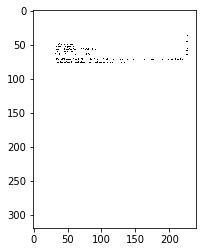

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted class: 1
gt class: 1


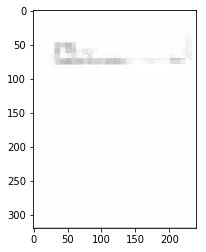

In [6]:
img, gt = tobacco[0]

plt.imshow(np.tile(np.transpose(img, (1,2,0)), 3))
plt.show()

img = img.cuda()
reconstructed_img, predicted_class = model(img.unsqueeze(0))

print("predicted class:", predicted_class.cpu().data.numpy().argmax())
print("gt class:", gt.item())

reconstructed_img = reconstructed_img.cpu().data.numpy()[0]
reconstructed_img = np.tile(np.transpose(reconstructed_img, (1,2,0)), 3)

plt.imshow(reconstructed_img)
plt.show()